# Formatting Gemini Data
## Ver 2
Formatting Gemini data for input into d3 dashboard

In [1]:
import pandas as pd
from tqdm import tqdm

Read in gemini data

In [2]:
%%time
with open("./gemini_pull_2019_01_16_18_07_06.txt", "r") as file:
    gemini = file.read()

CPU times: user 4 ms, sys: 4.02 ms, total: 8.03 ms
Wall time: 114 ms


Separate messages

In [3]:
%%time
gemini_list = gemini.replace("}{", "}\n{").split("\n")

CPU times: user 11.1 ms, sys: 3.87 ms, total: 15 ms
Wall time: 15.1 ms


In [4]:
len(gemini_list)

10844

The first message is larger, gives remaining interest for all price points at the time of socket open

In [5]:
[len(i) for i in gemini_list[:10]]

[386154, 219, 222, 220, 226, 224, 222, 220, 222, 219]

In [6]:
first_msg = gemini_list[0]

In [7]:
first_msg[:400]

'{"type":"update","eventId":5368619062,"socket_sequence":0,"events":[{"type":"change","reason":"initial","price":"0.01","delta":"191642.102","remaining":"191642.102","side":"bid"},{"type":"change","reason":"initial","price":"0.02","delta":"22959.5","remaining":"22959.5","side":"bid"},{"type":"change","reason":"initial","price":"0.03","delta":"33","remaining":"33","side":"bid"},{"type":"change","rea'

In [8]:
first_message_df = pd.read_json(gemini_list[0])

In [34]:
first_message_df.head()

,eventId,events,socket_sequence,type,remaining,delta,reason,price,side
0,5368619062,"{'remaining': '191642.102', 'delta': '191642.1...",0,change,191642.102,191642.102,initial,0.01,bid
1,5368619062,"{'remaining': '22959.5', 'delta': '22959.5', '...",0,change,22959.5,22959.5,initial,0.02,bid
2,5368619062,"{'remaining': '33', 'delta': '33', 'type': 'ch...",0,change,33,33,initial,0.03,bid
3,5368619062,"{'remaining': '0.00055', 'delta': '0.00055', '...",0,change,0.00055,0.00055,initial,0.04,bid
4,5368619062,"{'remaining': '3693', 'delta': '3693', 'type':...",0,change,3693,3693,initial,0.05,bid


In [35]:
event_keys = first_message_df["events"].iloc[0].keys()

In [36]:
for i in event_keys:
    first_message_df[i] = first_message_df["events"].map(lambda x: x[i])

In [37]:
first_message_df.head()

,eventId,events,socket_sequence,type,remaining,delta,reason,price,side
0,5368619062,"{'remaining': '191642.102', 'delta': '191642.1...",0,change,191642.102,191642.102,initial,0.01,bid
1,5368619062,"{'remaining': '22959.5', 'delta': '22959.5', '...",0,change,22959.5,22959.5,initial,0.02,bid
2,5368619062,"{'remaining': '33', 'delta': '33', 'type': 'ch...",0,change,33,33,initial,0.03,bid
3,5368619062,"{'remaining': '0.00055', 'delta': '0.00055', '...",0,change,0.00055,0.00055,initial,0.04,bid
4,5368619062,"{'remaining': '3693', 'delta': '3693', 'type':...",0,change,3693,3693,initial,0.05,bid


each price shows up once:

In [38]:
first_message_df.price.value_counts().head()

1362.00     1
12600.00    1
9788.00     1
5280.00     1
3120.00     1
Name: price, dtype: int64

delta always equals remaining:

In [39]:
len(first_message_df[first_message_df.remaining != first_message_df.delta])

0

In [40]:
initial_interest = first_message_df[["side", "price", "remaining"]].drop_duplicates()

In [41]:
len(initial_interest)

3585

In [42]:
gemini_list[1]

'{"type":"update","eventId":5368619071,"timestamp":1547662175,"timestampms":1547662175932,"socket_sequence":1,"events":[{"type":"change","side":"bid","price":"3614.45","remaining":"0","delta":"-0.04","reason":"cancel"}]}'

In [43]:
%%time
update_str = ", ".join(gemini_list[1:])

CPU times: user 2.72 ms, sys: 425 µs, total: 3.15 ms
Wall time: 3.17 ms


In [44]:
%%time
all_updates_df = pd.read_json("[{}]".format(update_str))

CPU times: user 165 ms, sys: 28.1 ms, total: 193 ms
Wall time: 195 ms


In [45]:
%%time
all_updates_df["num_events"] = all_updates_df.events.map(len)

CPU times: user 5.48 ms, sys: 0 ns, total: 5.48 ms
Wall time: 5.63 ms


In [46]:
for i in tqdm(event_keys):
    all_updates_df[i] = all_updates_df["events"].map(lambda x: x[-1][i] if i in x[-1].keys() else "missing")

100%|██████████| 6/6 [00:00<00:00, 84.96it/s]


In [47]:
all_updates_df["price_double"] = all_updates_df.price.astype("double").round(2)

In [48]:
all_updates_df.num_events.value_counts()

1    10645
2      198
Name: num_events, dtype: int64

In [49]:
trades = all_updates_df[all_updates_df.num_events == 2]

In [50]:
trades.iloc[:2]

,eventId,events,socket_sequence,timestamp,timestampms,type,num_events,remaining,delta,reason,price,side,price_double
37,5368619504,"[{'amount': '0.45', 'price': '3620.42', 'maker...",38,2019-01-16 18:09:37,2019-01-16 18:09:37.570,change,2,0.518,-0.45,trade,3620.42,bid,3620.42
107,5368620111,"[{'amount': '0.1', 'price': '3620.50', 'makerS...",108,2019-01-16 18:09:40,2019-01-16 18:09:40.469,change,2,0.611,-0.1,trade,3620.50,bid,3620.50


In [51]:
trades.sort_values("price_double").price_double.round(3).iloc[0]

3612.6399999999999

In [52]:
all_updates_df.price.map(len).value_counts()

7    10843
Name: price, dtype: int64

In [53]:
all_updates_df.price.nunique()

1775

In [133]:
all_updates_rest_df = pd.concat([
        all_updates_df[["price", "side", "timestampms", "remaining", "type"]],
        initial_interest]).reset_index().drop(columns = ["index"])

In [134]:
all_updates_df.shape

(10843, 14)

In [135]:
initial_interest.shape

(3585, 3)

In [136]:
all_updates_rest_df.shape

(14428, 5)

In [137]:
all_updates_rest_df["fixed_timestampms"] = all_updates_rest_df.timestampms.map(lambda x: x if pd.notnull(x) else all_updates_rest_df.timestampms.min())

In [138]:
all_updates_rest_df["fixed_type"] = all_updates_rest_df["type"].map(lambda x: x if pd.notnull(x) else "change")

In [139]:
all_updates_rest_df["price_padded"] = all_updates_rest_df.price.str.pad(7, "left", "0")

In [140]:
trades_range = [
    trades.price.str.pad(7, "left", "0").min(),
    trades.price.str.pad(7, "left", "0").max()]

In [141]:
all_updates_rest_df["fixed_type"].value_counts()

change         14427
block_trade        1
Name: fixed_type, dtype: int64

Exclude block trades

In [142]:
interest_changes = all_updates_rest_df[all_updates_rest_df["fixed_type"] == "change"][["fixed_timestampms", "price_padded", "remaining", "side"]]

In [143]:
interest_changes.shape

(14427, 4)

In [144]:
interest_changes_in_trades_range = interest_changes[interest_changes.price_padded.between(*trades_range)]

In [145]:
interest_changes_in_trades_range.shape

(6736, 4)

In [146]:
interest_changes_in_trades_range.dtypes

fixed_timestampms    datetime64[ns]
price_padded                 object
remaining                    object
side                         object
dtype: object

In [149]:
interest_changes_in_trades_range["next_tim"] = interest_changes_in_trades_range.sort_values(
    "fixed_timestampms").groupby(
    ["price_padded", "side"])["fixed_timestampms"].shift(-1)

/home/gautam_sisodia/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [150]:
interest_changes_in_trades_range.iloc[:10]

,fixed_timestampms,price_padded,remaining,side,next_tim
0,2019-01-16 18:09:35.932,3614.45,0,bid,2019-01-16 18:09:35.932
10,2019-01-16 18:09:36.331,3615.56,0.08,bid,2019-01-16 18:09:40.055
13,2019-01-16 18:09:36.470,3613.42,0.54,bid,2019-01-16 18:09:36.569
15,2019-01-16 18:09:36.546,3619.86,0,bid,NaT
16,2019-01-16 18:09:36.563,3619.54,6.8651,bid,2019-01-16 18:09:37.612
17,2019-01-16 18:09:36.569,3613.42,0.62,bid,2019-01-16 18:09:37.871
31,2019-01-16 18:09:37.209,3615.99,0.18,bid,2019-01-16 18:09:37.308
33,2019-01-16 18:09:37.308,3615.99,0.36,bid,2019-01-16 18:09:37.609
37,2019-01-16 18:09:37.570,3620.42,0.518,bid,2019-01-16 18:09:39.077
38,2019-01-16 18:09:37.609,3615.99,0.44,bid,2019-01-16 18:09:37.709


In [151]:
interest_changes_in_trades_range[interest_changes_in_trades_range.price_padded == "3614.45"]

,fixed_timestampms,price_padded,remaining,side,next_tim
0,2019-01-16 18:09:35.932,3614.45,0,bid,2019-01-16 18:09:35.932
7173,2019-01-16 18:19:33.636,3614.45,2,bid,2019-01-16 18:19:52.752
7331,2019-01-16 18:19:52.752,3614.45,0,bid,2019-01-16 18:24:50.302
9046,2019-01-16 18:24:50.302,3614.45,1.41370744,bid,2019-01-16 18:24:50.325
9052,2019-01-16 18:24:50.325,3614.45,0,bid,NaT
12694,2019-01-16 18:09:35.932,3614.45,0.04,bid,2019-01-16 18:19:33.636


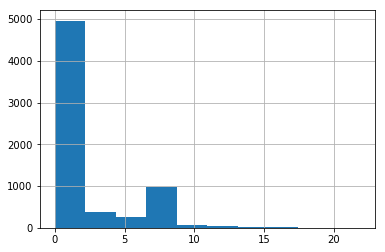

In [152]:
interest_changes_in_trades_range.remaining.astype("float").hist()

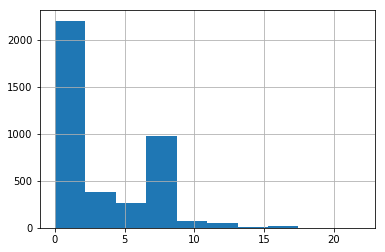

In [153]:
interest_changes_in_trades_range[interest_changes_in_trades_range.remaining.astype("float") > 0].remaining.astype("float").hist()

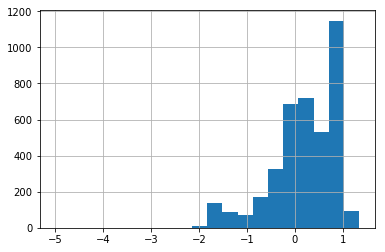

In [154]:
import numpy as np
interest_changes_in_trades_range[interest_changes_in_trades_range.remaining.astype("float") > 0].remaining.astype(
    "float").map(
    np.log10).hist(
    bins = 20)

Save interest change events

In [155]:
interest_changes_in_trades_range.to_json("gemini_interest.json", orient = "records")

Save trade events

In [156]:
all_updates_df[all_updates_df.reason == "trade"][["timestampms", "delta", "price"]].to_json("gemini_trades.json", orient = "records")